In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


In [2]:
!ls ../input/swimtransformercovid19

__notebook__.ipynb  __results___files  custom.css
__output__.json     bestmodel.pth      model1.pth
__results__.html    bestmodel.pth.pth  unfreeze_model.pth


In [3]:
pip install fastai==1.0.61

     |████████████████████████████████| 239 kB 4.4 MB/s 
     |████████████████████████████████| 115 kB 13.0 MB/s 
     |████████████████████████████████| 88 kB 5.1 MB/s 
  Installing build dependencies ... - \ | / - \ done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... - done
  Created wheel for bottleneck: filename=Bottleneck-1.3.2-cp37-cp37m-linux_x86_64.whl size=334952 sha256=ce93c82995bffb287b341c24df31a0918063c4c596615a170b817600e9570375
  Stored in directory: /root/.cache/pip/wheels/87/85/9c/a325c89ff0498660ef8a335fb4b3912939c273ea4f094af29f
Successfully built bottleneck
  Attempting uninstall: fastai
    Found existing installation: fastai 2.3.0
    Uninstalling fastai-2.3.0:
      Successfully uninstalled fastai-2.3.0
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install git+https://github.com/rwightman/pytorch-image-models.git

  Cloning https://github.com/rwightman/pytorch-image-models.git to /tmp/pip-req-build-ia5md2b0
  Running command git clone -q https://github.com/rwightman/pytorch-image-models.git /tmp/pip-req-build-ia5md2b0
  Created wheel for timm: filename=timm-0.4.9-py3-none-any.whl size=356561 sha256=630d13576f8d78482dd827b58e4e6a7452c072e76e1c8da40c46734e12699e5c
  Stored in directory: /tmp/pip-ephem-wheel-cache-bnstbufk/wheels/a0/ec/5f/289118b747739bb1e02e36cf3d7e759721e881c183653719dc
Successfully built timm
Note: you may need to restart the kernel to use updated packages.


In [5]:
import warnings
warnings.filterwarnings("ignore") 

In [6]:
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import torch
import torch.nn as nn
from torchvision.utils import make_grid
from torchvision.utils import save_image
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import random
%matplotlib inline

In [7]:

from fastai.vision import *
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [8]:
import fastai

In [9]:
!ls ../input/covid19-radiography-database/COVID-19_Radiography_Dataset

 COVID			      Normal.metadata.xlsx
 COVID.metadata.xlsx	      README.md.txt
 Lung_Opacity		     'Viral Pneumonia'
 Lung_Opacity.metadata.xlsx  'Viral Pneumonia.metadata.xlsx'
 Normal


In [10]:
source_dir = "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset"

random_seed = 42
np.random.seed(random_seed)
random.seed(random_seed)

epochs = 10

valid_split = 0.2

In [11]:
import pandas as pd

In [12]:
!ls ../input/covid19-radiography-database/COVID-19_Radiography_Dataset


 COVID			      Normal.metadata.xlsx
 COVID.metadata.xlsx	      README.md.txt
 Lung_Opacity		     'Viral Pneumonia'
 Lung_Opacity.metadata.xlsx  'Viral Pneumonia.metadata.xlsx'
 Normal


In [13]:
import glob
import cv2
import numpy as np
%matplotlib inline
filesCOVID= sorted(glob.glob('../input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/*.png'))
filesPnue=sorted(glob.glob('../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia/*.png'))
filesLungsOpt=sorted(glob.glob('../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Lung_Opacity/*.png'))
filesNormal=sorted(glob.glob('../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/*.png'))

In [14]:
filesLungsOpt=filesLungsOpt[:3500]
filesNormal=filesNormal[:3500]

In [15]:
len(filesCOVID),len(filesPnue),len(filesLungsOpt),len(filesNormal)

(3616, 1345, 3500, 3500)

In [16]:
norm_labels=[[i,0] for i in filesNormal]
lungs_labels=[[i,1] for i in filesLungsOpt]
pne_labels=[[i,2] for i in filesPnue]
covid_labels=[[i,3] for i in filesCOVID]
ds=norm_labels+lungs_labels+pne_labels+covid_labels

In [17]:
np.random.seed(4200)
import pandas as pd 
df = pd.DataFrame(ds,columns =['path', 'label']) 
def Randomizing(df):
    df2 = df.reindex(np.random.permutation(df.index))
    return df2
df=Randomizing(df)

In [18]:
def Randomizing(df):
    df2 = df.reindex(np.random.permutation(df.index))
    return df2

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
dftrain, dftest = train_test_split(df, test_size=0.15)

In [21]:

from fastai.vision import *
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [22]:

from fastai.vision import *

In [23]:
import fastai

In [24]:
import imp

In [25]:
imp.reload(fastai)
imp.reload(fastai.vision)

<module 'fastai.vision' from '/opt/conda/lib/python3.7/site-packages/fastai/vision/__init__.py'>

In [26]:
fastai.__version__

'1.0.61'

In [27]:
def custom_transform(img): # you get a PyTorch tensor as input, not a fastai Image object
    img = image2np(img)*255 # convert to numpy array in range 0-255
    img = img.astype(np.uint8) # convert to int

    # If your image is a regular colour image, remember it will be in RGB so convert to BGR if needed
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    lab_planes = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(16,16))
    lab_planes[0] = clahe.apply(lab_planes[0])
    lab = cv2.merge(lab_planes)
    bgr = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    
    return pil2tensor(bgr, dtype=np.float32)/255 # convert back to tensor and return

custom_trans = TfmPixel(custom_transform)

In [28]:
tfms_ = get_transforms(do_flip=True,flip_vert=False,max_lighting=0.4,max_zoom=1.1)

In [29]:
tfms_[1]

[RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True)]

In [30]:
tfms_[0].insert(0,custom_trans())

In [31]:
tfms_[1].insert(0,custom_trans())

In [32]:
bs =32
sz=224

src = (ImageList.from_df(df=dftrain,path='',cols='path') #get dataset from dataset
        .split_by_rand_pct(0.2) #Splitting the dataset
        .label_from_df(cols='label') #obtain labels from the level column
      )
data= (src.transform(tfms_,size=224,padding_mode='zeros') #Data augmentation
        .databunch(bs=bs,num_workers=4) #DataBunch
        .normalize(imagenet_stats) #Normalize     
       )

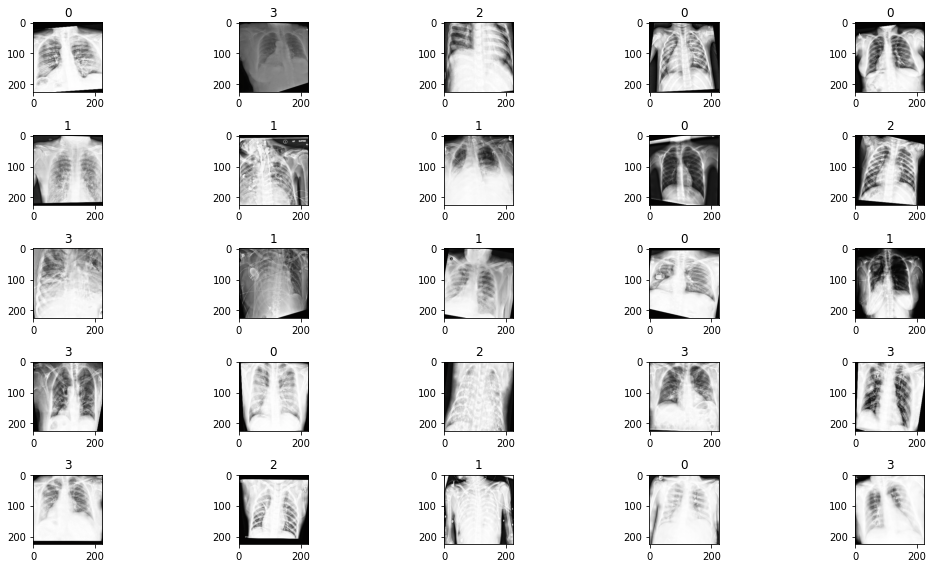

In [33]:
data.show_batch(rows=5, figsize=(15,8), hide_axis=False)

In [34]:
import torch 
import torchvision

In [35]:
import timm

m = timm.create_model('swin_base_patch4_window7_224', pretrained=True)

Downloading: "https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_base_patch4_window7_224_22kto1k.pth" to /root/.cache/torch/hub/checkpoints/swin_base_patch4_window7_224_22kto1k.pth


In [36]:
num_ftrs = m.head.in_features

In [37]:
m.head=nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(num_ftrs, 256),
    nn.Dropout(0.5),
    nn.Linear(256, 4),
)

In [38]:
data.classes

[0, 1, 2, 3]

In [39]:
model=m.cuda()

In [40]:
pwd

'/kaggle/working'

In [41]:
from fastai.callbacks import *

learn = Learner(data, model, metrics=[error_rate, accuracy])

In [42]:
learn.model_dir='/kaggle/working'

In [43]:
from fastai.callbacks import *




In [44]:
callbacks = [
        SaveModelCallback(learn,monitor='accuracy'),
    ]

learn.callbacks = callbacks

In [45]:
fastai.__version__

'1.0.61'

In [46]:
!ls

__notebook__.ipynb


In [47]:
# learn.fit(15,1e-05)

In [48]:
# learn.recorder.plot_losses()

In [49]:
# learn.save('unfreeze_model')

In [50]:
!ls ../input/swimtransformercovid19

__notebook__.ipynb  __results___files  custom.css
__output__.json     bestmodel.pth      model1.pth
__results__.html    bestmodel.pth.pth  unfreeze_model.pth


In [51]:
learn.load('../input/swimtransformercovid19/bestmodel')
learn.unfreeze()
learn.fit(25,1e-06)


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.105768,0.148288,0.049680,0.950320,03:28
1,0.126690,0.157788,0.052140,0.947860,03:26
2,0.121886,0.141817,0.048205,0.951795,03:25
3,0.110740,0.158155,0.053123,0.946877,03:25
4,0.119022,0.140877,0.044761,0.955239,03:25
5,0.109267,0.157398,0.052140,0.947860,03:26
6,0.096656,0.137475,0.048205,0.951795,03:27
7,0.107449,0.147651,0.049680,0.950320,03:26
8,0.091351,0.152641,0.049188,0.950812,03:26
9,0.104726,0.140291,0.047713,0.952287,03:27


Better model found at epoch 0 with accuracy value: 0.9503197073936462.
Better model found at epoch 2 with accuracy value: 0.9517953991889954.
Better model found at epoch 4 with accuracy value: 0.9552385807037354.


In [52]:
!ls

__notebook__.ipynb  bestmodel.pth


In [53]:
learn.load('bestmodel')
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)

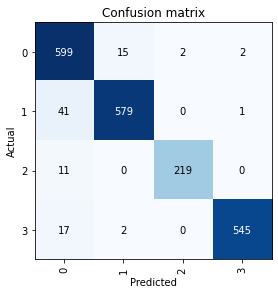

In [54]:
interp.plot_confusion_matrix()

In [55]:
learn.save('bestmodel.pth')

In [56]:
learn.save()

AttributeError: 'NoneType' object has no attribute 'flush'

In [57]:
# import gc
# del model,m
# gc.collect()

In [58]:
#     import torch
#     torch.cuda.empty_cache()